DivS: (divisive)<br>
Divisive suppression explains high-precision firing and contrast adaptation in retinal ganglion cells <br>
url = {https://dx.doi.org/10.7554/elife.19460} <br>

Chou's psi (Subtraction)<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('Modules')
except:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
from Spike_Generation import SG
from Spike_Generation import NL

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


In [3]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# k_E and k_S

In [4]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

In [5]:
m = 4.037925
n =	100
alpha = 8.351984
beta = 3.123359
g =  442.699730/n
tau_y = 0.050404

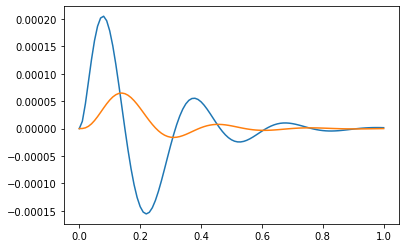

In [6]:
dt = 0.01
TKaxis = np.arange(101)*dt

k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)

# LPOU input

In [7]:
tot = 1000
Taxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(Taxis))
mu, sigma = 0, 1
for i in range(len(Taxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
x = (LPOU-np.mean(LPOU))/np.std(LPOU)

1.2486356534092602


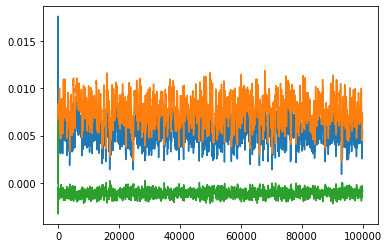

In [8]:
amp = 2
mean = 10

psi = 0.5

eOutput = np.convolve(x*amp+mean, k_E, 'full')[:len(x)]
sOutput = np.convolve(x*amp+mean, k_S, 'full')[:len(x)]
baseOutput = eOutput*(1-psi)-sOutput*psi

print(np.std(sOutput)/np.std(eOutput))
plt.plot(eOutput)
plt.plot(sOutput)
plt.plot(baseOutput)


In [14]:
psi_list = np.arange(0.,1.,0.05)
output = [0]*len(psi_list)
for i in range(len(psi_list)):
    output[i] = eOutput*(1-psi_list[i])-sOutput*psi_list[i]

### MI

In [15]:
window = [-1,1]
state_num = 6
xstate = EqualState(LPOU, state_num)[0]

MI = [0]*len(psi_list)
for i in range(len(psi_list)):
    # rstate, _ = np.histogram( Spike_Time_Generater(CCDM_output[i], dt, 10, 10), np.append(Taxis, tot))
    rstate =SG(output[i], dt, 0, 10, 10)
    timeshift, MI[i] = MIfunc(rstate, xstate, dt, window)

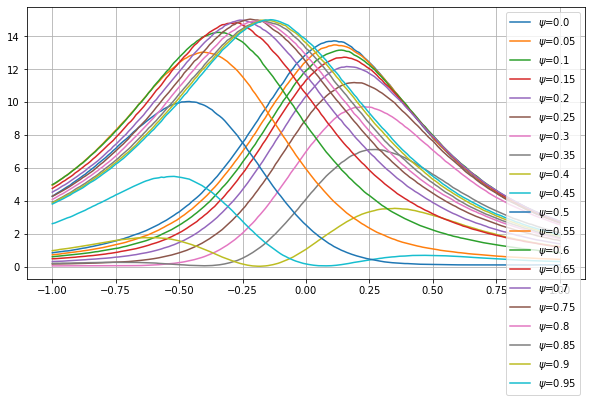

In [18]:
for i in range(len(psi_list)): 
    plt.plot(timeshift,MI[i], label = r'$\psi$='+str(round(psi_list[i],2)))
plt.legend()
plt.grid('on')
plt.gcf().set_size_inches(10,5)